# Home Credit Default Risk

### Exploratory Data Analysis Part

## Start

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

In [2]:
# List files available
print(os.listdir("./input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
# Description of the columns in the training data
descr = pd.read_csv('./input/HomeCredit_columns_description.csv', encoding= 'unicode_escape')
print('Column description shape: ', descr.shape)
descr

Column description shape:  (219, 5)


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


## Data Processing

We first use label encoding to encode all the categorical variables (dtype == object) with 2 unique categories, and then use one-hot encoding to encode the rest.

In [4]:
# Training data
app_train = pd.read_csv('./input/application_train.csv')

# Testing data features
app_test = pd.read_csv('./input/application_test.csv')

# Ohter sheets
POS_CASH_balance = pd.read_csv('./input/POS_CASH_balance.csv')
bureau_balance = pd.read_csv('./input/bureau_balance.csv')
previous_application = pd.read_csv('./input/previous_application.csv')
installments_payments = pd.read_csv('./input/installments_payments.csv')
credit_card_balance = pd.read_csv('./input/credit_card_balance.csv')
bureau = pd.read_csv('./input/bureau.csv')

In [5]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            

In [6]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## EDA

### Examine the Distribution of the Target Column

We first take a look at the label of the loan that we are trying to predict : `TARGET`, either a 0 for the loan was repaid, or a 1 for un unpaid.

0    282686
1     24825
Name: TARGET, dtype: int64


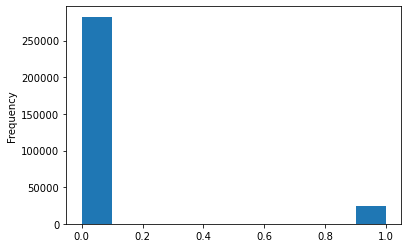

In [7]:
print(app_train['TARGET'].value_counts())
app_train['TARGET'].astype(int).plot.hist();

In [8]:
temp = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Loan Repayed or not')

We can see that this is an imbalanced class problem. There are far more loans that were repaid than loans that were not repaid.

### Examine Missing Values

We take the training data as an example.

In [9]:
# checking missing data
total = app_train.isnull().sum().sort_values(ascending = False)
percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
FLOORSMIN_MEDI,208642,67.848630


### Column Types

### Anomalies

### APP_train Correlations

In [10]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

In [57]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.04620

## Bureau

# Featuretools!!!

In [42]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


### Bureau Summary

|Coulumn           |    Explanation    |
| -------------      | -------------         |
|SK_ID_CURR         | 对应当前的loan|
|SK_ID_BUREAU       |previous loan的ID|
|CREDIT_ACTIVE       | Closed 已还， active待还|
|CREDIT_CURRENCY     | 货币编码，有无作用待看|
|DAYS_CREDIT        |申请时间|
|CREDIT_DAY_OVERDUE   | 逾期天数 ？|
|DAYS_CREDIT_ENDDATE   | 截止时间|
|DAYS_ENDDATE_FACT    | 完成偿还时间（只有closed才有）|
|AMT_CREDIT_MAX_OVERDUE| 最大逾期金额 ？|
|CNT_CREDIT_PROLONG   | 多少次延长|
|AMT_CREDIT_SUM      | 借贷金额|
|AMT_CREDIT_SUM_DEBT   |待还金额|
|AMT_CREDIT_SUM_LIMIT  | 借贷上限|
|AMT_CREDIT_SUM_OVERDUE| 到期未付金额|
|CREDIT_TYPE | 借贷性质|
|DAYS_CREDIT_UPDATE   | 接待前信息更新天数|
|AMT_ANNUITY        | 借贷年费|

#### Question : 

DAYS_ENDDATE_FACT < DAYS_CREDIT_ENDDATE,

AMT_CREDIT_MAX_OVERDUE > 0

In [58]:
days_data = bureau[['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE']]
days_data = days_data.dropna()
days_data

,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE
7,-1684.0,-1710.0,14985.000
8,-811.0,-840.0,0.000
19,-77.0,-77.0,0.000
24,-2561.0,-2559.0,310.500
25,-7.0,-343.0,20493.270
...,...,...,...
1716413,-36.0,-36.0,6863.715
1716414,-1320.0,-1320.0,5693.625
1716418,-1299.0,-1299.0,0.000
1716419,-1596.0,-1625.0,8100.000


In [52]:
(bureau['AMT_CREDIT_SUM_OVERDUE']).loc[bureau['AMT_CREDIT_SUM_OVERDUE'] > 0]

365           231.525
785           288.000
936            58.500
1575          504.000
1791       169582.500
              ...    
1707833       193.500
1709570        22.500
1709789        22.500
1710139       234.000
1713547       171.000
Name: AMT_CREDIT_SUM_OVERDUE, Length: 4158, dtype: float64

In [54]:
(bureau).loc[bureau['AMT_ANNUITY'] > 0]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
769,380361,5715449,Active,currency 1,-357,0,1119.0,NaN,NaN,0,45000.0,0.00,45000.0,0.0,Credit card,-130,2691.00
781,125263,5715463,Active,currency 1,-462,0,273.0,NaN,0.000,0,121131.0,52763.58,0.0,0.0,Consumer credit,-5,24462.00
787,275240,5715470,Closed,currency 1,-2341,0,-1974.0,-1974.0,NaN,0,112500.0,0.00,0.0,0.0,Consumer credit,-1496,8181.00
789,275240,5715472,Closed,currency 1,-1147,0,-964.0,-969.0,NaN,0,88848.0,0.00,0.0,0.0,Consumer credit,-968,8181.00
790,399518,5715473,Closed,currency 1,-941,0,NaN,-823.0,NaN,0,0.0,0.00,NaN,0.0,Credit card,-466,8061.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716274,129052,5053576,Active,currency 1,-1229,0,4619.0,NaN,NaN,0,576000.0,573318.00,NaN,0.0,Credit card,-9,43735.50
1716275,129052,5053577,Closed,currency 1,-2870,0,-2564.0,-2564.0,1611.045,0,15705.0,0.00,0.0,0.0,Consumer credit,-2557,43735.50
1716285,435426,5053678,Closed,currency 1,-1147,0,-416.0,-849.0,0.000,0,205488.0,0.00,0.0,0.0,Consumer credit,-835,94378.50
1716290,363575,5053740,Closed,currency 1,-1234,0,-503.0,-502.0,NaN,0,900000.0,0.00,0.0,0.0,Consumer credit,-461,58554.00


In [61]:
(bureau).loc[bureau['CREDIT_CURRENCY'] == 'currency 1'].head(20)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


In [62]:
(bureau).loc[bureau['CREDIT_CURRENCY'] != 'currency 1'].head(20)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1436,108012,5716224,Closed,currency 2,-2889,0,-1063.0,-1061.0,NaN,0,2790000.0,0.00,0.0,0.0,Consumer credit,-1059,NaN
1475,430110,5716274,Closed,currency 2,-1974,0,-1609.0,-1758.0,NaN,0,177444.0,0.00,NaN,0.0,Consumer credit,-1756,NaN
2071,316711,5717036,Closed,currency 2,-2194,0,-1830.0,-1815.0,NaN,0,1181286.0,NaN,NaN,0.0,Car loan,-1815,NaN
6835,253537,5722696,Closed,currency 2,-2817,0,-1723.0,-2773.0,NaN,0,4737420.0,0.00,0.0,0.0,Car loan,-1510,NaN
8303,270344,5724552,Closed,currency 4,-1791,0,35.0,-1365.0,0.00,0,973350.0,0.00,0.0,0.0,Consumer credit,-1365,NaN
9067,374135,5725496,Closed,currency 2,-1805,0,-709.0,-712.0,NaN,0,1491255.0,473463.00,NaN,0.0,Consumer credit,-637,NaN
9928,314837,5726554,Closed,currency 2,-2870,0,-1063.0,-1147.0,NaN,0,7136820.0,0.00,0.0,0.0,Car loan,-1145,0.0
15026,450588,6024541,Closed,currency 3,-2045,0,-1680.0,-1680.0,NaN,0,429089.4,0.00,NaN,0.0,Consumer credit,-1678,37964.7
20582,403642,5195000,Active,currency 2,-1804,0,3736.0,NaN,0.00,0,28458000.0,8841825.27,0.0,0.0,Mortgage,-49,NaN
23654,327124,5198617,Closed,currency 2,-2511,0,-684.0,-1748.0,NaN,0,5022000.0,0.00,0.0,0.0,Car loan,-1431,NaN


In [56]:
(bureau).loc[bureau['CREDIT_DAY_OVERDUE'] != 0]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
365,282297,5714943,Active,currency 1,-2712,2603,-2498.0,NaN,4590.0,0,24696.000,231.525,0.0,231.525,Consumer credit,-1077,NaN
785,408647,5715468,Active,currency 1,-313,6,233.0,NaN,NaN,0,417208.500,214947.000,0.0,288.000,Consumer credit,-5,NaN
936,380677,5715645,Active,currency 1,-2659,30,-2353.0,NaN,NaN,0,57024.000,0.000,NaN,58.500,Consumer credit,-493,NaN
1575,218135,5716400,Active,currency 1,-2543,2156,-2172.0,NaN,NaN,0,45000.000,NaN,NaN,504.000,Consumer credit,-2156,NaN
1791,229323,5716671,Active,currency 1,-757,496,NaN,NaN,NaN,0,225000.000,NaN,NaN,169582.500,Consumer credit,-4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707319,226956,5027625,Active,currency 1,-52,19,224.0,NaN,2151.0,0,23701.500,18819.000,0.0,22.500,Consumer credit,-18,NaN
1707833,108883,5028638,Active,currency 1,-907,20,553.0,NaN,NaN,0,135000.000,137119.500,NaN,193.500,Credit card,-13,0.0
1709570,141935,5582069,Active,currency 1,-80,20,1016.0,NaN,22.5,0,166137.255,160812.000,0.0,22.500,Consumer credit,-11,NaN
1709789,385777,5582323,Active,currency 1,-126,24,606.0,NaN,NaN,0,405000.000,362002.500,0.0,22.500,Consumer credit,-9,NaN


## Bureau_balance

In [65]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


### Bureau_balance Summary

|Coulumn      |    Explanation   |
| -------------  | -------------    |
|SK_ID_BUREAU   | previous loan的ID |
|MONTHS_BALANCE  | 对应月份       |
|STATUS       | 还款状态 ？     |

## Credit_card_balance 

In [66]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [ ]:
### Bureau Summary

|Coulumn            |    Explanation    |
| -------------     | -------------         |
|SK_ID_PREV         | 
|SK_ID_CURR         | 对应当前的loan|
|MONTHS_BALANCE     | 对应月份       |
|AMT_BALANCE        | 